<a href="https://colab.research.google.com/github/RicardoArielMenna/Procesamiento/blob/main/Procesamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cargo los archivos

In [107]:
import pandas as pd
from google.colab import drive, files

# 1. Cargar datos
drive.mount('/content/drive')
ruta = r'/content/drive/My Drive/Proyecto/DATOS/NIR/NIR_E1.csv'
df = pd.read_csv(ruta)
ruta_p= r'/content/drive/My Drive/Proyecto/DATOS/Parametros/Parametros_E1_PasoAlsina.csv'
df_parametros = pd.read_csv(ruta_p, encoding="latin-1")
print(df.head())
#print(df_parametros.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   3999.706  4003.563   4007.42  4011.277  4015.134  4018.991  4022.848  \
0  0.293456  0.293087  0.292833  0.292430  0.292046  0.291612  0.291175   
1  0.291955  0.291748  0.291650  0.291327  0.291022  0.290792  0.290509   
2  0.284005  0.283690  0.283421  0.283131  0.282868  0.282529  0.282233   
3  0.291955  0.291748  0.291650  0.291327  0.291022  0.290792  0.290509   
4  0.289187  0.288883  0.288579  0.288289  0.288043  0.287725  0.287433   

   4026.705  4030.562  4034.419  ...  9981.907  9985.765  9989.621  9993.479  \
0  0.290683  0.290201  0.289691  ...  0.245202  0.245129  0.245033  0.245016   
1  0.290203  0.289838  0.289509  ...  0.280499  0.280432  0.280406  0.280387   
2  0.281932  0.281659  0.281326  ...  0.264087  0.264003  0.263900  0.263847   
3  0.290203  0.289838  0.289509  ...  0.280499  0.280432  0.280406  0.280387   
4  0.287092  0.28680

Preprocesamiento datos NIR

In [108]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter

# Separar datos espectrales de los metadatos
nir_spectral_data = df.iloc[:, :-4]  # Todas menos las últimas 4 columnas
nir_metadata = df.iloc[:, -4:]       # Las últimas 4 columnas (archivo, estacion, etc.)

# Paso 1: Derivada de Savitzky-Golay (suaviza y elimina baseline)
nir_deriv = savgol_filter(nir_spectral_data.values, window_length=11, polyorder=2, deriv=1, axis=1)

# Paso 2: Normalización (escalado estándar)
scaler = StandardScaler()
nir_scaled = scaler.fit_transform(nir_deriv)

# Reconstruir DataFrame con nombres originales
df_nir_preprocessed= pd.DataFrame(nir_scaled, columns=nir_spectral_data.columns)

# Agregar de nuevo los metadatos si se desea
df_nir_final = pd.concat([df_nir_preprocessed, nir_metadata.reset_index(drop=True)], axis=1)

# Mostrar resultado
print(df_nir_final.head())


   3999.706  4003.563   4007.42  4011.277  4015.134  4018.991  4022.848  \
0  0.035463  0.030985  0.026806  0.022919  0.019307  0.015955  0.013694   
1  0.397809  0.395731  0.393153  0.390219  0.387041  0.383711  0.382856   
2  0.110806  0.166493  0.217513  0.264211  0.306942  0.346057  0.362488   
3  0.397809  0.395731  0.393153  0.390219  0.387041  0.383711  0.382856   
4  0.128889  0.177924  0.222797  0.263824  0.301327  0.335623  0.345289   

   4026.705  4030.562  4034.419  ...  9981.907  9985.765  9989.621  9993.479  \
0  0.008595  0.006877  0.011411  ...  0.377828  0.118208 -0.072155 -0.192633   
1  0.379699  0.376739  0.372138  ... -0.353169  0.012788  0.265619  0.419331   
2  0.372524  0.381067  0.388139  ... -1.224329 -1.286497 -1.218480 -1.129254   
3  0.379699  0.376739  0.372138  ... -0.353169  0.012788  0.265619  0.419331   
4  0.350884  0.358276  0.371654  ... -0.781381 -0.125072  0.341146  0.630105   

   9997.335  10001.19         archivo  estacion  campania  replica  

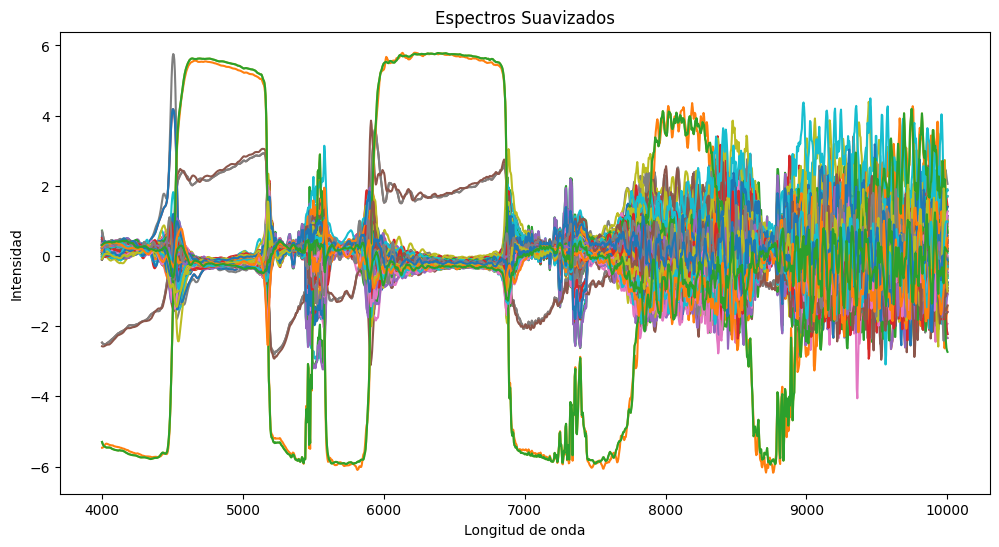

In [109]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
for i in range(len(df_nir_final)-1):  # Cambia el rango para ver más o menos espectros
    plt.plot(df_nir_preprocessed.columns.astype(float), df_nir_preprocessed.iloc[i], label=f'Espectro {i}')
plt.xlabel('Longitud de onda')
plt.ylabel('Intensidad')
plt.title('Espectros Suavizados')
plt.show()

Sacar outliers

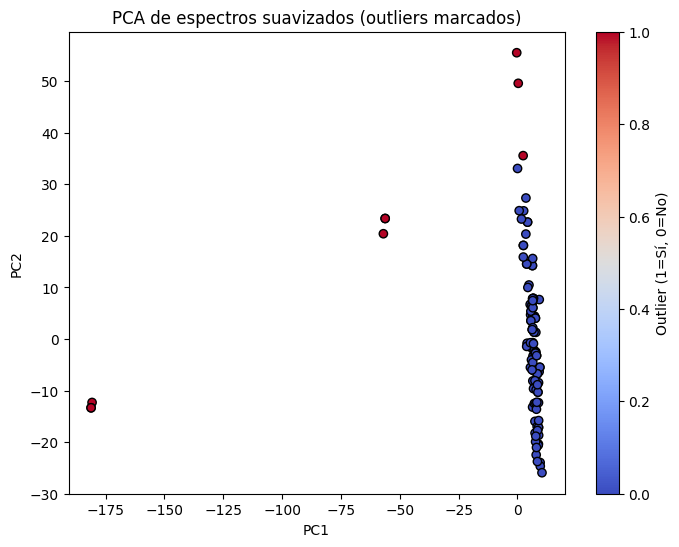

In [110]:
from sklearn.decomposition import PCA
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

# 1. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_nir_preprocessed)

# 2. Calcular distancia Mahalanobis
mean = np.mean(X_pca, axis=0)
cov = np.cov(X_pca, rowvar=False)
inv_covmat = np.linalg.inv(cov)
diff = X_pca - mean
md = np.sqrt(np.sum(diff @ inv_covmat * diff, axis=1))

# 3. Definir umbral
threshold = np.sqrt(chi2.ppf(0.91, df=2))

# 4. Crear la columna de outliers
df_nir_preprocessed['Outlier'] = (md >= threshold).astype(int)

# 5. (Opcional) Agregar componentes principales para análisis o visualización
df_nir_preprocessed['PC1'] = X_pca[:, 0]
df_nir_preprocessed['PC2'] = X_pca[:, 1]

# 6. Graficar con color según outlier
plt.figure(figsize=(8, 6))
plt.scatter(df_nir_preprocessed['PC1'], df_nir_preprocessed['PC2'],
            c=df_nir_preprocessed['Outlier'], cmap='coolwarm', edgecolors='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA de espectros suavizados (outliers marcados)')
plt.colorbar(label='Outlier (1=Sí, 0=No)')
plt.show()


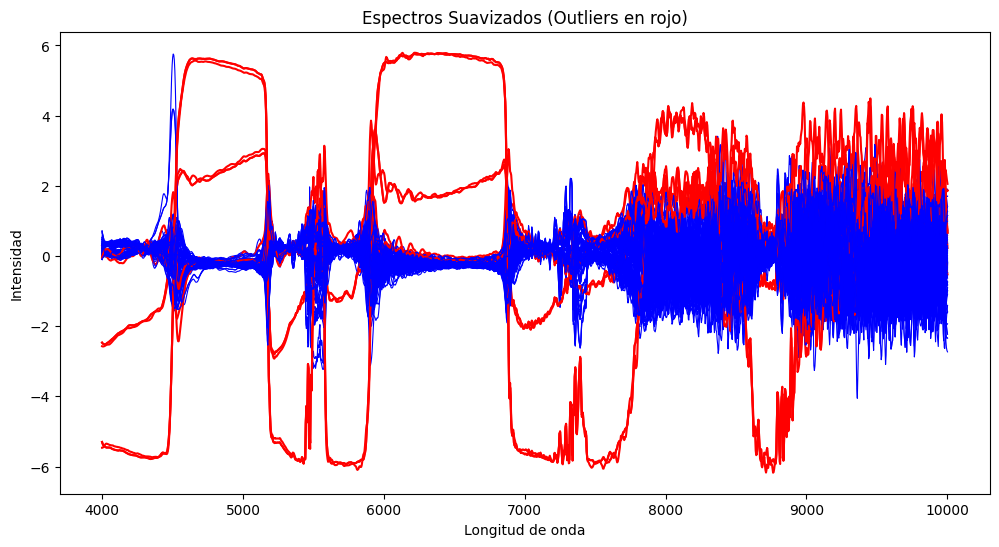

In [111]:
# Agregar de nuevo los metadatos si se desea
df_nir_final = pd.concat([df_nir_preprocessed, nir_metadata.reset_index(drop=True)], axis=1)
df_nir_preprocessed = df_nir_final.iloc[:, :-7]

plt.figure(figsize=(12,6))

for i in range(len(df_nir_final)):
    if df_nir_final.loc[i, 'Outlier'] == 1:
        color = 'red'
        linewidth = 1.5
    else:
        color = 'blue'
        linewidth = 0.8

    plt.plot(df_nir_preprocessed.columns.astype(float), df_nir_preprocessed.iloc[i],
             color=color, linewidth=linewidth)

plt.xlabel('Longitud de onda')
plt.ylabel('Intensidad')
plt.title('Espectros Suavizados (Outliers en rojo)')
plt.show()

Filtro de los parámetros aquellos que cuentan con datos NIR

In [112]:
df_parametros = df_parametros[df_parametros['Espectros NIR'] == 1].reset_index(drop=True)
print(df_nir_final.head())

   3999.706  4003.563   4007.42  4011.277  4015.134  4018.991  4022.848  \
0  0.035463  0.030985  0.026806  0.022919  0.019307  0.015955  0.013694   
1  0.397809  0.395731  0.393153  0.390219  0.387041  0.383711  0.382856   
2  0.110806  0.166493  0.217513  0.264211  0.306942  0.346057  0.362488   
3  0.397809  0.395731  0.393153  0.390219  0.387041  0.383711  0.382856   
4  0.128889  0.177924  0.222797  0.263824  0.301327  0.335623  0.345289   

   4026.705  4030.562  4034.419  ...  9993.479  9997.335  10001.19  Outlier  \
0  0.008595  0.006877  0.011411  ... -0.192633 -0.269414 -0.320739        0   
1  0.379699  0.376739  0.372138  ...  0.419331  0.514526  0.576814        0   
2  0.372524  0.381067  0.388139  ... -1.129254 -1.052115 -0.990688        0   
3  0.379699  0.376739  0.372138  ...  0.419331  0.514526  0.576814        0   
4  0.350884  0.358276  0.371654  ...  0.630105  0.811581  0.931588        0   

        PC1        PC2         archivo  estacion  campania  replica  
0  6

Uno los dataframes

In [115]:
df_nir_final.rename(columns={'campania': 'Campania'}, inplace=True)
df_unificado = df_parametros.merge(df_nir_final, on="Campania", how='left')
#df_unificado.to_csv('prueba.csv', index=False)
#files.download('prueba.csv')

Verificar unión

In [114]:
print("Shape df_parametros:", df_parametros.shape)
print("Shape df_nir_final:", df_nir_final.shape)
print("Shape df_unificado:", df_unificado.shape)

# Verificar si hay valores NaN después del merge
print(df_unificado.isna().sum())

Shape df_parametros: (38, 23)
Shape df_nir_final: (114, 1564)
Shape df_unificado: (114, 1586)
Fecha         0
Irrigacion    0
Campania      0
Na+ (mg/L)    0
K+ (mg/L)     0
             ..
PC1           0
PC2           0
archivo       0
estacion      0
replica       0
Length: 1586, dtype: int64


Entrenamiento

--- Optimización de PLS con Validación Cruzada ---
Dimensiones de X_pls para PLS (después de alineación y NaN handling): (114, 1557)
Dimensiones de y_pls para PLS (después de alineación y NaN handling): (114,)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 460.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py", line 719, in fit
    super().fit(X, y)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi

Mejor número de componentes PLS: 1
Mejor R² (validación cruzada): -1.497


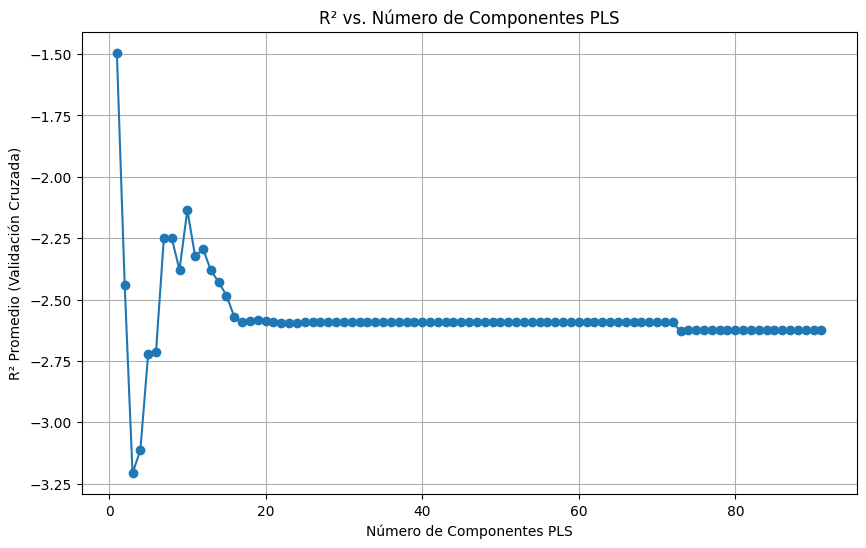


--- Evaluación del modelo PLS óptimo ---
R² (PLS Óptimo en Test): 0.006512860370763596
MAE (PLS Óptimo en Test): 223.1894584413274


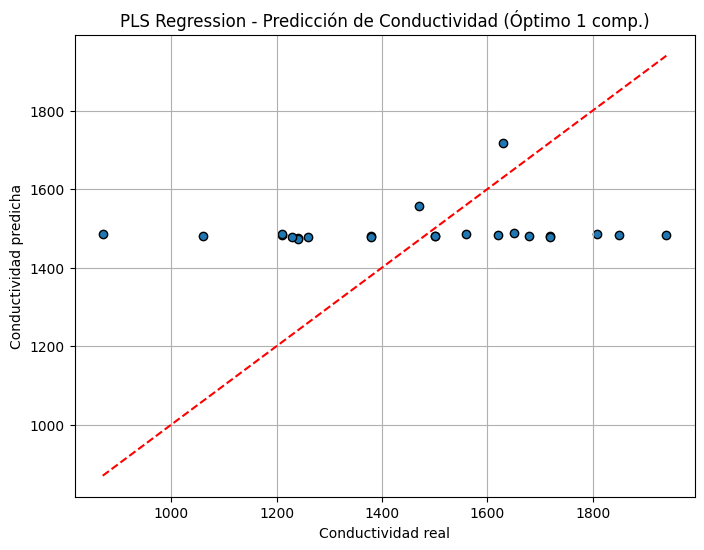

No se pudo graficar los coeficientes PLS: las columnas de X_pls no son numéricas.


In [134]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

print("--- Optimización de PLS con Validación Cruzada ---")

spectral_columns_original = nir_spectral_data.columns

# Ahora, seleccionamos esas columnas de df_unificado.
# Esto asume que df_unificado contiene las columnas espectrales con sus nombres originales.
X_pls = df_unificado[spectral_columns_original].copy()
y_pls = df_unificado['CE (us/cm)'].copy()


# Crea un DataFrame temporal para manejar los NaNs y asegurar la alineación
df_temp_aligned = pd.DataFrame(X_pls)
df_temp_aligned['CE (us/cm)'] = y_pls

# Eliminar filas con NaN en las columnas relevantes para el modelo
df_temp_aligned.dropna(subset=list(X_pls.columns) + ['CE (us/cm)'], inplace=True)

X_pls = df_temp_aligned[X_pls.columns]
y_pls = df_temp_aligned['CE (us/cm)']

print(f"Dimensiones de X_pls para PLS (después de alineación y NaN handling): {X_pls.shape}")
print(f"Dimensiones de y_pls para PLS (después de alineación y NaN handling): {y_pls.shape}")

# Si después de manejar los NaNs, X_pls queda vacío, esto causará un error.
if X_pls.shape[1] == 0:
    raise ValueError("X_pls no tiene columnas espectrales. Revisa la definición de spectral_columns_original y df_unificado.")
if X_pls.shape[0] == 0:
    raise ValueError("X_pls no tiene filas (muestras). Revisa el proceso de unificación y manejo de NaN.")

# Definir el rango de componentes a probar
# n_components_range = np.arange(1, min(X_pls.shape[1], X_pls.shape[0]) + 1) # ANTES

# DESPUÉS (con un ajuste para CV)
max_components_safe = min(X_pls.shape[1], X_pls.shape[0] - (X_pls.shape[0] // 5)) # Para cv=5
n_components_range = np.arange(1, max_components_safe + 1)

# Asegúrate de que n_components_range no esté vacío
if len(n_components_range) == 0:
    # Esto ocurre si max_components_safe es 0 o negativo
    print(f"Advertencia: n_components_range está vacío. Max_components_safe es {max_components_safe}. Ajustando a 1.")
    n_components_range = np.array([1]) # Si no hay más opciones, al menos probamos 1 componente

# Grid Search para encontrar el número óptimo de componentes PLS
scorer = make_scorer(r2_score)
param_grid = {'n_components': n_components_range}
pls_model = PLSRegression()

grid_search = GridSearchCV(pls_model, param_grid, cv=5, scoring=scorer, verbose=0, n_jobs=-1)
grid_search.fit(X_pls, y_pls)

print(f"Mejor número de componentes PLS: {grid_search.best_params_['n_components']}")
print(f"Mejor R² (validación cruzada): {grid_search.best_score_:.3f}")

# Graficar el rendimiento de R^2 vs. número de componentes
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, grid_search.cv_results_['mean_test_score'], marker='o')
plt.xlabel('Número de Componentes PLS')
plt.ylabel('R² Promedio (Validación Cruzada)')
plt.title('R² vs. Número de Componentes PLS')
plt.grid(True)
plt.show()

# Entrenar el modelo PLS final con el número óptimo de componentes
optimal_n_components = grid_search.best_params_['n_components']
pls_optimal = PLSRegression(n_components=optimal_n_components)

# Dividir los datos nuevamente para una evaluación final con el modelo óptimo
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_pls, y_pls, test_size=0.2, random_state=42
)

pls_optimal.fit(X_train_final, y_train_final)
y_pred_optimal = pls_optimal.predict(X_test_final).flatten()

print("\n--- Evaluación del modelo PLS óptimo ---")
print("R² (PLS Óptimo en Test):", r2_score(y_test_final, y_pred_optimal))
print("MAE (PLS Óptimo en Test):", mean_absolute_error(y_test_final, y_pred_optimal))

# Gráfico de Predicción Final con Modelo PLS Óptimo
plt.figure(figsize=(8, 6))
plt.scatter(y_test_final, y_pred_optimal, edgecolors='k')
plt.xlabel("Conductividad real")
plt.ylabel("Conductividad predicha")
plt.title(f"PLS Regression - Predicción de Conductividad (Óptimo {optimal_n_components} comp.)")
plt.plot([y_pls.min(), y_pls.max()], [y_pls.min(), y_pls.max()], 'r--')
plt.grid(True)
plt.show()

# OPCIONAL: Visualización de los coeficientes del modelo PLS
if X_pls.columns.dtype == float or X_pls.columns.dtype == int or all(isinstance(c, (int, float)) for c in X_pls.columns):
    plt.figure(figsize=(12, 6))
    plt.plot(X_pls.columns.astype(float), pls_optimal.coef_.flatten())
    plt.xlabel('Longitud de Onda')
    plt.ylabel('Coeficiente PLS')
    plt.title('Coeficientes del Modelo PLS Óptimo')
    plt.grid(True)
    plt.show()
else:
    print("No se pudo graficar los coeficientes PLS: las columnas de X_pls no son numéricas.")